Based on kernels and discussions:

  - https://www.kaggle.com/jsaguiar/lightgbm-with-simple-features
    
  - https://github.com/mvahit/home_credit (collaboration with the community of Veri Bilimi Okulu that I also joined)
    
  - https://www.kaggle.com/c/home-credit-default-risk/discussion/64821

In [1]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
"""
Input should be a dataframe (df) and the function reduces data sizes of the df
Note: If you have problems with this function try to discard Float16 part as
there might be errors because of this data type:
https://github.com/pandas-dev/pandas/issues/9220
"""
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

Time function for tracking run times of functions

In [3]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))


One-hot encoding function for categorical variables with get_dummies

In [4]:
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns) # col names as string in a list 
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object'] #categorical col names
    df = pd.get_dummies(df, columns = categorical_columns, dummy_na = nan_as_category) #creating dummies
    new_columns = [c for c in df.columns if c not in original_columns] #new col names
    return df, new_columns

def label_encoder(df):
    # Create a label encoder object
    le = LabelEncoder()
    le_count = 0

    # Iterate through the columns
    for col in df:
        if df[col].dtype == 'object':
            # If 2 or fewer unique categories
            if len(list(df[col].unique())) <= 2:
                # Train on the training data
                le.fit(df[col])
                # Transform both training and testing data
                df[col] = le.transform(df[col])

                # Keep track of how many columns were label encoded
                le_count += 1

    print('%d columns were label encoded.' % le_count)
    
    return df

In [5]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    df = pd.read_csv("../input/home-credit-default-risk/application_train.csv", nrows = num_rows)
    test_df = pd.read_csv("../input/home-credit-default-risk/application_test.csv", nrows = num_rows)

    df = df.append(test_df).reset_index()
    del df["index"]
    
    df = df[df['CODE_GENDER'] != 'XNA']
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)

    df['APP_NEW_AGE'] = df['DAYS_BIRTH'] / (- 365.25)
    
    # Some simple new features (percentages)
    df['APP_NEW_DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['APP_NEW_INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['APP_NEW_INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['APP_NEW_ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['APP_NEW_PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    df["APP_NEW_CREDIT_GOODS_PRICE_RATIO"] = df["AMT_CREDIT"] / df["AMT_GOODS_PRICE"]
    df["APP_NEW_CREDIT_DOWNPAYMENT"] = df["AMT_GOODS_PRICE"] - df["AMT_CREDIT"]

    df.loc[(df.AMT_INCOME_TOTAL < 30000),'APP_NEW_INCOME_BAND'] = 1
    df.loc[(df.AMT_INCOME_TOTAL >= 30000)&(df.AMT_INCOME_TOTAL < 65000),'APP_NEW_INCOME_BAND'] = 2
    df.loc[(df.AMT_INCOME_TOTAL >= 65000)&(df.AMT_INCOME_TOTAL < 95000),'APP_NEW_INCOME_BAND'] = 3
    df.loc[(df.AMT_INCOME_TOTAL >= 95000)&(df.AMT_INCOME_TOTAL < 130000),'APP_NEW_INCOME_BAND'] = 4
    df.loc[(df.AMT_INCOME_TOTAL >= 130000)&(df.AMT_INCOME_TOTAL < 160000),'APP_NEW_INCOME_BAND'] = 5
    df.loc[(df.AMT_INCOME_TOTAL >= 160000)&(df.AMT_INCOME_TOTAL < 190000),'APP_NEW_INCOME_BAND'] = 6
    df.loc[(df.AMT_INCOME_TOTAL >= 190000)&(df.AMT_INCOME_TOTAL < 220000),'APP_NEW_INCOME_BAND'] = 7
    df.loc[(df.AMT_INCOME_TOTAL >= 220000)&(df.AMT_INCOME_TOTAL < 275000),'APP_NEW_INCOME_BAND'] = 8
    df.loc[(df.AMT_INCOME_TOTAL >= 275000)&(df.AMT_INCOME_TOTAL < 325000),'APP_NEW_INCOME_BAND'] = 9
    df.loc[(df.AMT_INCOME_TOTAL >= 325000),'APP_NEW_INCOME_BAND'] = 10
    
    APP_NEW_AGE_CAT = pd.Series(["Young", "Adult 1","Adult 2","Adult 3", "Adult 4"], dtype = "object")
    df["APP_NEW_AGE_CAT"] = APP_NEW_AGE_CAT
    df.loc[(df["APP_NEW_AGE"] > 20.0) & (df["APP_NEW_AGE"] <= 30.0), "APP_NEW_AGE_CAT"] = APP_NEW_AGE_CAT[0]
    df.loc[(df["APP_NEW_AGE"] > 30.0) & (df["APP_NEW_AGE"] <= 40.0), "APP_NEW_AGE_CAT"] = APP_NEW_AGE_CAT[1]
    df.loc[(df["APP_NEW_AGE"] > 40.0) & (df["APP_NEW_AGE"] <= 50.0), "APP_NEW_AGE_CAT"] = APP_NEW_AGE_CAT[2]
    df.loc[(df["APP_NEW_AGE"] > 50.0) & (df["APP_NEW_AGE"] <= 60.0), "APP_NEW_AGE_CAT"] = APP_NEW_AGE_CAT[3]
    df.loc[df["APP_NEW_AGE"] > 60 ,"APP_NEW_AGE_CAT"] = APP_NEW_AGE_CAT[4]
    
    df["APP_NEW_AGE_DAYS_EMP"] = df["DAYS_EMPLOYED"] / (- 365.25)
    df["APP_NEW_AGE_WORK_PERCENT"] = (df["APP_NEW_AGE_DAYS_EMP"] / df['APP_NEW_AGE']) * 100
    df['APP_NEW_CREDIT_INCOME_PERCENT'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
    df['APP_NEW_ANNUITY_INCOME_PERCENT'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['APP_NEW_DAYS_EMPLOYED_PERCENT'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['APP_NEW_INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['APP_NEW_INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['APP_NEW_PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    df['APP_NEW_AMT_PAY_YEAR'] = df['AMT_CREDIT'] / df['AMT_ANNUITY'] 
    df['APP_NEW_AGE_PAYOFF'] = df['APP_NEW_AGE'] + df['APP_NEW_AMT_PAY_YEAR']
    df['APP_NEW_AMT_DIFF_CREDIT_GOODS'] = df['AMT_CREDIT'] - df['AMT_GOODS_PRICE'] 
    df['APP_NEW_AMT_CREDIT_GOODS_PERC'] = ((df['AMT_GOODS_PRICE'] / df['AMT_CREDIT']) * 100)
    df['APP_NEW_CNT_ADULT'] = df['CNT_FAM_MEMBERS'] - df['CNT_CHILDREN']
    df['APP_NEW_EXT_SOURCES_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    df['APP_NEW_EXT_SOURCES_MAX'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].max(axis=1)
    df['APP_NEW_EXT_SOURCES_SUM'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].sum(axis=1)

    df = label_encoder(df)
 
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category) #returns: encoded new df and cat col names
   
    del test_df
    gc.collect()
    return df

In [6]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('../input/home-credit-default-risk/bureau.csv', nrows = num_rows)
    bureau_balance = pd.read_csv('../input/home-credit-default-risk/bureau_balance.csv', nrows = num_rows)
    
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    def _status_to_int(status):
        if status in ['X', 'C']:
            return 0
        if pd.isnull(status):
            return np.nan
        return int(status)

    bureau_balance['NEW_BUREAU_BALANCE_DPD_LEVEL'] = bureau_balance['STATUS'].apply(_status_to_int)
    bureau_balance['NEW_BUREAU_BALANCE_STATUS_UNKNOWN'] = (bureau_balance['STATUS'] == 'X').astype(int)  

    bureau_balance["MONTHS_BALANCE"] = (-1*bureau_balance["MONTHS_BALANCE"])+1

    bb_aggregations = {'MONTHS_BALANCE': ["max"],
                    'NEW_BUREAU_BALANCE_DPD_LEVEL':['sum', 'mean', 'max', 'std', 'skew'],
                    'NEW_BUREAU_BALANCE_STATUS_UNKNOWN':['sum', 'mean']}

    bb_agg = bureau_balance.groupby('SK_ID_BUREAU').agg(bb_aggregations)

    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bureau_balance, bb_agg
    gc.collect()
    
     # Bureau new features
    bureau.drop(["AMT_CREDIT_SUM_LIMIT","AMT_CREDIT_SUM_OVERDUE","CREDIT_DAY_OVERDUE","AMT_CREDIT_SUM_OVERDUE"],axis=1,inplace=True)
    bureau['BUREAU_CREDIT_TYPE_CONSUMER'] = (bureau['CREDIT_TYPE'] == 'Consumer credit').astype(int)
    bureau['BUREAU_CREDIT_TYPE_CAR'] = (bureau['CREDIT_TYPE'] == 'Car loan').astype(int)
    bureau['BUREAU_CREDIT_TYPE_MORTGAGE'] = (bureau['CREDIT_TYPE'] == 'Mortgage').astype(int)
    bureau['BUREAU_CREDIT_TYPE_CREDIT_CARD'] = (bureau['CREDIT_TYPE'] == 'Credit card').astype(int)
    bureau['BUREAU_CREDIT_TYPE_OTHER'] = (~(bureau['CREDIT_TYPE'].isin(['Consumer credit', 'Car loan', 'Mortgage', 'Credit card']))).astype(int)
    bureau['BUREAU_UNUSUAL_CURRENCY'] = (~(bureau['CREDIT_CURRENCY'] == 'currency 1')).astype(int)
    
    bureau['NEW_PAYMENT_RATE_SUM'] = bureau['AMT_ANNUITY'] / bureau['AMT_CREDIT_SUM']
    bureau['NEW_PAYMENT_RATE_SUM_DEBT'] = bureau['AMT_ANNUITY'] / bureau['AMT_CREDIT_SUM_DEBT']
    bureau['NEW_PAYMENT_RATE_AMT_CREDIT_MAX_OVERDUE'] = bureau['AMT_ANNUITY'] / bureau['AMT_CREDIT_MAX_OVERDUE']
    
    bureau.drop(["CREDIT_TYPE","CREDIT_CURRENCY"],axis=1,inplace=True)
    
    bureau.loc[(bureau["CREDIT_ACTIVE"]=="Active")&(bureau["DAYS_CREDIT_ENDDATE"]>-42056.001)&(bureau["DAYS_CREDIT_ENDDATE"]<=-1773.0),"BUREAU_NEW_ACTIVE_EARLY_PAYERS_SCORE"] = 1
    bureau.loc[(bureau["CREDIT_ACTIVE"]=="Active")&(bureau["DAYS_CREDIT_ENDDATE"]>-1773.0)&(bureau["DAYS_CREDIT_ENDDATE"]<=-1273.0),"BUREAU_NEW_ACTIVE_EARLY_PAYERS_SCORE"] = 2
    bureau.loc[(bureau["CREDIT_ACTIVE"]=="Active")&(bureau["DAYS_CREDIT_ENDDATE"]>-1273.0)&(bureau["DAYS_CREDIT_ENDDATE"]<=-777.0),"BUREAU_NEW_ACTIVE_EARLY_PAYERS_SCORE"] = 3
    bureau.loc[(bureau["CREDIT_ACTIVE"]=="Active")&(bureau["DAYS_CREDIT_ENDDATE"]>-777.0)&(bureau["DAYS_CREDIT_ENDDATE"]<=-474.0),"BUREAU_NEW_ACTIVE_EARLY_PAYERS_SCORE"] = 4
    bureau.loc[(bureau["CREDIT_ACTIVE"]=="Active")&(bureau["DAYS_CREDIT_ENDDATE"]>-474.0)&(bureau["DAYS_CREDIT_ENDDATE"]<=-268.0),"BUREAU_NEW_ACTIVE_EARLY_PAYERS_SCORE"] = 5
    bureau.loc[(bureau["CREDIT_ACTIVE"]=="Active")&(bureau["DAYS_CREDIT_ENDDATE"]>-268.0)&(bureau["DAYS_CREDIT_ENDDATE"]<=-133.0),"BUREAU_NEW_ACTIVE_EARLY_PAYERS_SCORE"] = 6
    bureau.loc[(bureau["CREDIT_ACTIVE"]=="Active")&(bureau["DAYS_CREDIT_ENDDATE"]>-133.0)&(bureau["DAYS_CREDIT_ENDDATE"]<=-38.0),"BUREAU_NEW_ACTIVE_EARLY_PAYERS_SCORE"] = 7
    bureau.loc[(bureau["CREDIT_ACTIVE"]=="Active")&(bureau["DAYS_CREDIT_ENDDATE"]>-38.0)&(bureau["DAYS_CREDIT_ENDDATE"]<=-1.0),"BUREAU_NEW_ACTIVE_EARLY_PAYERS_SCORE"] = 8 
    
    bureau.loc[(bureau["CREDIT_ACTIVE"]=="Closed")&(bureau["DAYS_ENDDATE_FACT"]<bureau["DAYS_CREDIT_ENDDATE"])&(bureau["DAYS_ENDDATE_FACT"]>-42023.001)&(bureau["DAYS_ENDDATE_FACT"]<=-2145.0),"BUREAU_NEW_CLOSED_EARLY_PAYERS_SCORE"] = 1
    bureau.loc[(bureau["CREDIT_ACTIVE"]=="Closed")&(bureau["DAYS_ENDDATE_FACT"]<bureau["DAYS_CREDIT_ENDDATE"])&(bureau["DAYS_ENDDATE_FACT"]>-2145.0)&(bureau["DAYS_ENDDATE_FACT"]<=-1598.0),"BUREAU_NEW_CLOSED_EARLY_PAYERS_SCORE"] = 2
    bureau.loc[(bureau["CREDIT_ACTIVE"]=="Closed")&(bureau["DAYS_ENDDATE_FACT"]<bureau["DAYS_CREDIT_ENDDATE"])&(bureau["DAYS_ENDDATE_FACT"]>-1598.0)&(bureau["DAYS_ENDDATE_FACT"]<=-1191.0),"BUREAU_NEW_CLOSED_EARLY_PAYERS_SCORE"] = 3
    bureau.loc[(bureau["CREDIT_ACTIVE"]=="Closed")&(bureau["DAYS_ENDDATE_FACT"]<bureau["DAYS_CREDIT_ENDDATE"])&(bureau["DAYS_ENDDATE_FACT"]>-1191.0)&(bureau["DAYS_ENDDATE_FACT"]<=-902.),"BUREAU_NEW_CLOSED_EARLY_PAYERS_SCORE"] = 4
    bureau.loc[(bureau["CREDIT_ACTIVE"]=="Closed")&(bureau["DAYS_ENDDATE_FACT"]<bureau["DAYS_CREDIT_ENDDATE"])&(bureau["DAYS_ENDDATE_FACT"]>-902.)&(bureau["DAYS_ENDDATE_FACT"]<=-656.0),"BUREAU_NEW_CLOSED_EARLY_PAYERS_SCORE"] = 5
    bureau.loc[(bureau["CREDIT_ACTIVE"]=="Closed")&(bureau["DAYS_ENDDATE_FACT"]<bureau["DAYS_CREDIT_ENDDATE"])&(bureau["DAYS_ENDDATE_FACT"]>-656.0)&(bureau["DAYS_ENDDATE_FACT"]<=-439.0),"BUREAU_NEW_CLOSED_EARLY_PAYERS_SCORE"] = 6
    bureau.loc[(bureau["CREDIT_ACTIVE"]=="Closed")&(bureau["DAYS_ENDDATE_FACT"]<bureau["DAYS_CREDIT_ENDDATE"])&(bureau["DAYS_ENDDATE_FACT"]>-439.0)&(bureau["DAYS_ENDDATE_FACT"]<=-229.0),"BUREAU_NEW_CLOSED_EARLY_PAYERS_SCORE"] = 7
    bureau.loc[(bureau["CREDIT_ACTIVE"]=="Closed")&(bureau["DAYS_ENDDATE_FACT"]<bureau["DAYS_CREDIT_ENDDATE"])&(bureau["DAYS_ENDDATE_FACT"]>-229.0)&(bureau["DAYS_ENDDATE_FACT"]<=0.0),"BUREAU_NEW_CLOSED_EARLY_PAYERS_SCORE"] = 8
    
    bureau.loc[(bureau["CREDIT_ACTIVE"]=="Closed")&(bureau["DAYS_ENDDATE_FACT"]>bureau["DAYS_CREDIT_ENDDATE"])&(bureau["DAYS_ENDDATE_FACT"]>-2876.001)&(bureau["DAYS_ENDDATE_FACT"]<=-2046.0),"BUREAU_NEW_CLOSED_LATE_PAYERS_SCORE"] = 1
    bureau.loc[(bureau["CREDIT_ACTIVE"]=="Closed")&(bureau["DAYS_ENDDATE_FACT"]>bureau["DAYS_CREDIT_ENDDATE"])&(bureau["DAYS_ENDDATE_FACT"]>-2046.0)&(bureau["DAYS_ENDDATE_FACT"]<=-1501.0),"BUREAU_NEW_CLOSED_LATE_PAYERS_SCORE"] = 2
    bureau.loc[(bureau["CREDIT_ACTIVE"]=="Closed")&(bureau["DAYS_ENDDATE_FACT"]>bureau["DAYS_CREDIT_ENDDATE"])&(bureau["DAYS_ENDDATE_FACT"]>-1501.0)&(bureau["DAYS_ENDDATE_FACT"]<=-1182.0),"BUREAU_NEW_CLOSED_LATE_PAYERS_SCORE"] = 3
    bureau.loc[(bureau["CREDIT_ACTIVE"]=="Closed")&(bureau["DAYS_ENDDATE_FACT"]>bureau["DAYS_CREDIT_ENDDATE"])&(bureau["DAYS_ENDDATE_FACT"]>-1182.0)&(bureau["DAYS_ENDDATE_FACT"]<=-1012.0),"BUREAU_NEW_CLOSED_LATE_PAYERS_SCORE"] = 4
    bureau.loc[(bureau["CREDIT_ACTIVE"]=="Closed")&(bureau["DAYS_ENDDATE_FACT"]>bureau["DAYS_CREDIT_ENDDATE"])&(bureau["DAYS_ENDDATE_FACT"]>-1012.0)&(bureau["DAYS_ENDDATE_FACT"]<=-878.0),"BUREAU_NEW_CLOSED_LATE_PAYERS_SCORE"] = 5
    bureau.loc[(bureau["CREDIT_ACTIVE"]=="Closed")&(bureau["DAYS_ENDDATE_FACT"]>bureau["DAYS_CREDIT_ENDDATE"])&(bureau["DAYS_ENDDATE_FACT"]>-878.0)&(bureau["DAYS_ENDDATE_FACT"]<=-615.0),"BUREAU_NEW_CLOSED_LATE_PAYERS_SCORE"] = 6
    bureau.loc[(bureau["CREDIT_ACTIVE"]=="Closed")&(bureau["DAYS_ENDDATE_FACT"]>bureau["DAYS_CREDIT_ENDDATE"])&(bureau["DAYS_ENDDATE_FACT"]>-615.0)&(bureau["DAYS_ENDDATE_FACT"]<=-307.0),"BUREAU_NEW_CLOSED_LATE_PAYERS_SCORE"] = 7
    bureau.loc[(bureau["CREDIT_ACTIVE"]=="Closed")&(bureau["DAYS_ENDDATE_FACT"]>bureau["DAYS_CREDIT_ENDDATE"])&(bureau["DAYS_ENDDATE_FACT"]>-307.0)&(bureau["DAYS_ENDDATE_FACT"]<=0.0),"BUREAU_NEW_CLOSED_LATE_PAYERS_SCORE"] = 8
    
    bureau['BUREAU_NEW_DAYS_CREDIT_SCORE'] = pd.qcut(bureau['DAYS_CREDIT'],10,labels=[10.0,9.0,8.0,7.0,6.0,5.0,4.0,3.0,2.0,1.0])
    
    bureau.loc[(bureau["CREDIT_ACTIVE"]=="Active")&(bureau["BUREAU_NEW_DAYS_CREDIT_SCORE"] == 10),"BUREAU_NEW_LAST_ACTIVE_DAYS_CREDIT"] = 1
    

    # Bureau and bureau_balance numeric features
    num_aggregations = {
        "DAYS_CREDIT": ['min', 'max', 'mean', 'var', 'sum'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'DAYS_ENDDATE_FACT': ['mean', 'sum'],
        'AMT_ANNUITY': ['min', 'max', 'mean', 'var', 'sum'],
        'CNT_CREDIT_PROLONG': ['sum','std'],
        'MONTHS_BALANCE_MAX': ['max'],
        "NEW_BUREAU_BALANCE_DPD_LEVEL_SUM" :['max',"sum"],
        "NEW_BUREAU_BALANCE_DPD_LEVEL_MEAN" :['max',"sum","mean"],
        "NEW_BUREAU_BALANCE_DPD_LEVEL_MAX" :['max',"sum"],
        "NEW_BUREAU_BALANCE_DPD_LEVEL_STD" :['max',"sum","std"],
        "NEW_BUREAU_BALANCE_DPD_LEVEL_SKEW" :['max',"sum","skew"],
        "NEW_BUREAU_BALANCE_STATUS_UNKNOWN_SUM" :['max',"sum"],
        "NEW_BUREAU_BALANCE_STATUS_UNKNOWN_MEAN" :['max',"sum","mean"],
        'BUREAU_CREDIT_TYPE_CONSUMER': ['mean', 'sum'],
        'BUREAU_CREDIT_TYPE_CAR': ['mean', 'sum'],
        'BUREAU_CREDIT_TYPE_MORTGAGE': ['mean', 'sum'],
        'BUREAU_CREDIT_TYPE_CREDIT_CARD': ['mean', 'sum'],
        'BUREAU_CREDIT_TYPE_OTHER': ['mean', 'sum'],
        'BUREAU_UNUSUAL_CURRENCY': ['mean', 'sum'],
        'NEW_PAYMENT_RATE_SUM':['max',"mean","sum"],
        'NEW_PAYMENT_RATE_SUM_DEBT':['max',"mean","sum"],
        'NEW_PAYMENT_RATE_AMT_CREDIT_MAX_OVERDUE':['max',"mean","sum",'min'],
        'BUREAU_NEW_ACTIVE_EARLY_PAYERS_SCORE':['mean','sum','max','min'],
        'BUREAU_NEW_CLOSED_EARLY_PAYERS_SCORE':['mean','sum','max','min'],
        'BUREAU_NEW_CLOSED_LATE_PAYERS_SCORE':['mean','sum','max','min'],       
    }
    
    # Bureau and bureau_balance categorical features
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [7]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    
    df = pd.read_csv("../input/home-credit-default-risk/previous_application.csv", nrows = num_rows)
    
    df.replace(365243,np.nan,inplace = True)
    df.replace("XNA",np.nan,inplace = True)

    df['NEW_RETURN_DAY'] = df['DAYS_DECISION'] + df['CNT_PAYMENT'] * 30

    df['NEW_DAYS_TERMINATION_diff'] = df['DAYS_TERMINATION'] - df['NEW_RETURN_DAY']

    df['NEW_AMT_DOWN_PAYMENT_rate'] = df['AMT_DOWN_PAYMENT'] / (df['AMT_CREDIT'] + 0.01)

    df['NEW_AMT_SPEND_TO_PRODUCT'] = df['AMT_GOODS_PRICE'] / df['AMT_CREDIT']
    
    df['NEW_DAYS_DUE']=df['DAYS_FIRST_DUE'] - df['DAYS_LAST_DUE_1ST_VERSION'] 
    
    df['NEW_APP_CREDIT_PERC'] = df['AMT_APPLICATION'] / df['AMT_CREDIT']
    
    df["NAME_PAYMENT_TYPE"].replace(["Non-cash from your account","Cashless from the account of the employer"],np.nan,inplace=True)

    a = ["Channel of corporate sales","Car dealer"]
    df["CHANNEL_TYPE"].replace(a,"Others_Type",inplace=True)

    b = ['Family', 'Spouse, partner', 'Children', 'Other_B', 'Other_A', 'Group of people'] 
    df["NAME_TYPE_SUITE"] = df["NAME_TYPE_SUITE"].replace(b, 'not_alone')

    df["WEEKDAY_APPR_PROCESS_START"] = df["WEEKDAY_APPR_PROCESS_START"].replace(['MONDAY','TUESDAY', 'WEDNESDAY','THURSDAY','FRIDAY'], 'WEEK_DAY') 
    df["WEEKDAY_APPR_PROCESS_START"] = df["WEEKDAY_APPR_PROCESS_START"].replace(['SATURDAY', 'SUNDAY'], 'WEEKEND')

    a = ['Auto technology', 'Jewelry', 'MLM partners', 'Tourism'] 
    df["NAME_SELLER_INDUSTRY"] = df["NAME_SELLER_INDUSTRY"].replace(a, 'Other_Ind')

    a = ['Auto Accessories', 'Jewelry', 'Homewares', 'Medical Supplies', 'Vehicles', 'Sport and Leisure','Gardening', 'Other', 'Office Appliances', 'Tourism', 'Medicine', 'Direct Sales', 'Fitness', 'Additional Service','Education', 'Weapon', 'Insurance', 'House Construction', 'Animals']  
    df["NAME_GOODS_CATEGORY"] = df["NAME_GOODS_CATEGORY"].replace(a, 'Other_Cat')

    a = ['Buying a used car','Building a house or an annex','Everyday expenses','Medicine','Payments on other loans','Education','Journey', 'Purchase of electronic equipment','Buying a new car','Wedding / gift / holiday','Buying a home','Car repairs','Furniture','Buying a holiday home / land', 'Business development','Gasification / water supply','Buying a garage','Hobby','Money for a third person','Refusal to name the goal','Urgent needs','Other']
    df['NAME_CASH_LOAN_PURPOSE']= df['NAME_CASH_LOAN_PURPOSE'].replace(a,'Others')
    

    df["NAME_PORTFOLIO"].replace("cars",np.nan,inplace=True)
    
    a = [8,9,10,11,12,13,14,15,16,17]
    df["HOUR_APPR_PROCESS_START"] = df["HOUR_APPR_PROCESS_START"].replace(a, 'Working_Hours')

    b = [18,19,20,21,22,23,0,1,2,3,4,5,6,7]
    df["HOUR_APPR_PROCESS_START"] = df["HOUR_APPR_PROCESS_START"].replace(b, 'Off_Hours')
    
    drops = ["RATE_INTEREST_PRIMARY","RATE_INTEREST_PRIVILEGED","FLAG_LAST_APPL_PER_CONTRACT","NFLAG_LAST_APPL_IN_DAY","NAME_PRODUCT_TYPE","SELLERPLACE_AREA"]
    df.drop(drops,inplace=True,axis=1)
    
    df["NFLAG_INSURED_ON_APPROVAL"] = df["NFLAG_INSURED_ON_APPROVAL"].astype("object")
    cat_features = list(df.select_dtypes(['object']).columns)
    df = pd.get_dummies(df, columns= cat_features, dummy_na= True,drop_first=True)
    
    agg1 = {'SK_ID_CURR': ['size'],
    'AMT_ANNUITY': ['max', 'min', 'mean','std', 'sum'],
    'AMT_APPLICATION':['max', 'min', 'mean','std', 'sum'],
    'AMT_CREDIT':['max', 'min', 'mean','std', 'sum'],
    'AMT_DOWN_PAYMENT': ['max', 'min', 'mean','std', 'sum'],
    'AMT_GOODS_PRICE': ['max', 'min', 'mean','std', 'sum'],
    'RATE_DOWN_PAYMENT': ['max', 'min', 'mean','std'],
    'DAYS_DECISION': ['max', 'min', 'mean', 'sum'],
    'CNT_PAYMENT': ['max', 'min', 'mean','std', 'sum'],
    'DAYS_FIRST_DRAWING': ['max','mean', 'sum'],
    'DAYS_FIRST_DUE': ['max', 'min', 'mean', 'sum'],
    'DAYS_LAST_DUE_1ST_VERSION': ['max', 'min', 'mean', 'sum'],
    'DAYS_LAST_DUE': ['max', 'min', 'mean', 'sum'],
    'DAYS_TERMINATION': ['max', 'min', 'mean','std', 'sum'],
    'NEW_RETURN_DAY': ['max', 'min', 'mean','std', 'sum'],
    'NEW_DAYS_TERMINATION_diff': ['max', 'mean','std', 'sum'],
    'NEW_AMT_DOWN_PAYMENT_rate': ['max','mean','std'],
    'NEW_AMT_SPEND_TO_PRODUCT': ['max', 'mean','std', 'sum'],
    'NEW_APP_CREDIT_PERC': ['max', 'min', 'mean'],
    'NAME_CONTRACT_TYPE_Consumer loans': ['max', 'min','sum'],
    'NAME_CONTRACT_TYPE_Revolving loans': ['max', 'min','sum'],
    'NAME_CONTRACT_TYPE_nan': ['max', 'min','sum'],
    'WEEKDAY_APPR_PROCESS_START_WEEK_DAY': ['max', 'min', 'sum'],
    'WEEKDAY_APPR_PROCESS_START_nan': ['max', 'sum'],
    'HOUR_APPR_PROCESS_START_Working_Hours': ['max', 'min', 'sum'],
    'HOUR_APPR_PROCESS_START_nan': ['max','sum'],
    'NAME_CASH_LOAN_PURPOSE_Repairs': ['max', 'min', 'sum'],
    'NAME_CASH_LOAN_PURPOSE_XAP': ['max', 'sum'],
    'NAME_CASH_LOAN_PURPOSE_nan': ['max', 'sum'],
    'NAME_CONTRACT_STATUS_Canceled': ['max','sum'],
    'NAME_CONTRACT_STATUS_Refused': ['max','sum'],
    'NAME_CONTRACT_STATUS_Unused offer': ['max','sum'],
    'NAME_CONTRACT_STATUS_nan': ['max', 'sum'],
    'NAME_PAYMENT_TYPE_nan': ['max', 'sum'],
    'CODE_REJECT_REASON_HC': ['max', 'min','sum'],
    'CODE_REJECT_REASON_LIMIT': ['max', 'min','sum'],
    'CODE_REJECT_REASON_SCO': ['max', 'min','sum'],
    'CODE_REJECT_REASON_SCOFR': ['max', 'sum'],
    'CODE_REJECT_REASON_VERIF': ['max',  'sum'],
    'CODE_REJECT_REASON_XAP': ['max',  'sum'],
    'CODE_REJECT_REASON_nan': ['max','sum'],
    'NAME_TYPE_SUITE_not_alone': ['max', 'min','sum'],
    'NAME_TYPE_SUITE_nan': ['max', 'min', 'sum'],
    'NAME_CLIENT_TYPE_Refreshed': ['max', 'min','sum'],
    'NAME_CLIENT_TYPE_Repeater': ['max', 'min', 'sum'],
    'NAME_CLIENT_TYPE_nan': ['max', 'min','sum'],
    'NAME_GOODS_CATEGORY_Clothing and Accessories': ['max', 'min', 'sum'],
    'NAME_GOODS_CATEGORY_Computers': ['max', 'min','sum'],
    'NAME_GOODS_CATEGORY_Construction Materials': ['max', 'min', 'sum'],
    'NAME_GOODS_CATEGORY_Consumer Electronics': ['max', 'min', 'sum'],
    'NAME_GOODS_CATEGORY_Furniture': ['max', 'min', 'sum'],
    'NAME_GOODS_CATEGORY_Mobile': ['max', 'min', 'sum'],
    'NAME_GOODS_CATEGORY_Other_Cat': ['max', 'min', 'sum'],
    'NAME_GOODS_CATEGORY_Photo / Cinema Equipment': ['max', 'min', 'sum'],
    'NAME_GOODS_CATEGORY_nan': ['max', 'min', 'sum'],
    'NAME_PORTFOLIO_Cars': ['max', 'min', 'sum'],
    'NAME_PORTFOLIO_Cash': ['max', 'min', 'sum'],
    'NAME_PORTFOLIO_POS': ['max', 'min','sum'],
    'NAME_PORTFOLIO_nan': ['max', 'min', 'sum'],
    'CHANNEL_TYPE_Contact center': ['max', 'min', 'sum'],
    'CHANNEL_TYPE_Country-wide': ['max', 'min', 'sum'],
    'CHANNEL_TYPE_Credit and cash offices': ['max', 'min', 'sum'],
    'CHANNEL_TYPE_Others_Type': ['max', 'min', 'sum'],
    'CHANNEL_TYPE_Regional / Local': ['max', 'min','sum'],
    'CHANNEL_TYPE_Stone': ['max', 'min','sum'],
    'CHANNEL_TYPE_nan': ['max', 'min', 'sum'],
    'NAME_SELLER_INDUSTRY_Connectivity': ['max', 'min','sum'],
    'NAME_SELLER_INDUSTRY_Construction': ['max', 'min', 'sum'],
    'NAME_SELLER_INDUSTRY_Consumer electronics': ['max', 'min',  'sum'],
    'NAME_SELLER_INDUSTRY_Furniture': ['max', 'min', 'sum'],
    'NAME_SELLER_INDUSTRY_Industry': ['max', 'min', 'sum'],
    'NAME_SELLER_INDUSTRY_Other_Ind': ['max', 'min','sum'],
    'NAME_SELLER_INDUSTRY_nan': ['max', 'min','sum'],
    'NAME_YIELD_GROUP_low_action': ['max', 'min', 'sum'],
    'NAME_YIELD_GROUP_low_normal': ['max', 'min', 'sum'],
    'NAME_YIELD_GROUP_middle': ['max', 'min','sum'],
    'NAME_YIELD_GROUP_nan': ['max', 'min','sum'],
    'PRODUCT_COMBINATION_Card X-Sell': ['max', 'min', 'sum'],
    'PRODUCT_COMBINATION_Cash': ['max', 'min', 'sum'],
    'PRODUCT_COMBINATION_Cash Street: high': ['max', 'min', 'sum'],
    'PRODUCT_COMBINATION_Cash Street: low': ['max', 'min','sum'],
    'PRODUCT_COMBINATION_Cash Street: middle': ['max', 'min','sum'],
    'PRODUCT_COMBINATION_Cash X-Sell: high': ['max', 'min','sum'],
    'PRODUCT_COMBINATION_Cash X-Sell: low': ['max', 'min','sum'],
    'PRODUCT_COMBINATION_Cash X-Sell: middle': ['max', 'min','sum'],
    'PRODUCT_COMBINATION_POS household with interest': ['max', 'min','sum'],
    'PRODUCT_COMBINATION_POS household without interest': ['max', 'min','sum'],
    'PRODUCT_COMBINATION_POS industry with interest': ['max', 'min','sum'],
    'PRODUCT_COMBINATION_POS industry without interest': ['max', 'min','sum'],
    'PRODUCT_COMBINATION_POS mobile with interest': ['max', 'min','sum'],
    'PRODUCT_COMBINATION_POS mobile without interest': ['max', 'min','sum'],
    'PRODUCT_COMBINATION_POS other with interest': ['max', 'min','sum'],
    'PRODUCT_COMBINATION_POS others without interest': ['max', 'min','sum'],
    'PRODUCT_COMBINATION_nan': ['max', 'min','sum'],
    'NFLAG_INSURED_ON_APPROVAL_1.0': ['max', 'min','sum'],
    'NFLAG_INSURED_ON_APPROVAL_nan': ['max', 'min','sum']}
    df = df.groupby(['SK_ID_CURR']).agg(agg1)
    
    df.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in df.columns.tolist()])

    return df

In [8]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    df=pd.read_csv('../input/home-credit-default-risk/POS_CASH_balance.csv',nrows = num_rows)
    
    df['NEW_ADJOURNMENT']=df['SK_DPD']-df['SK_DPD_DEF']
    
    b = ["Demand","Returned to the store","Approved","Amortized debt","Canceled","XNA"]
    df["NAME_CONTRACT_STATUS"].replace(b, 'Others',inplace=True)
    
    
    cat_features = list(df.select_dtypes(['object']).columns)
    df = pd.get_dummies(df, columns= cat_features, dummy_na= True)
    
    
    agg={
    'MONTHS_BALANCE': ['max'],
    'SK_DPD': ['max', 'mean',"std"],
    'SK_DPD_DEF': ['max', 'mean',"std"],
    'CNT_INSTALMENT':['min','mean','max'],
    'CNT_INSTALMENT_FUTURE':['mean','min','max'],
    'SK_ID_CURR':['max','size'],
    'NEW_ADJOURNMENT':['max','mean',"std"],
    'NAME_CONTRACT_STATUS_Active':['sum'],
    'NAME_CONTRACT_STATUS_Completed':['sum'],
    'NAME_CONTRACT_STATUS_Signed':['sum'],
    'NAME_CONTRACT_STATUS_Others':['sum']
    }
    
    
    pos_agg = df.groupby(['SK_ID_PREV']).agg(agg)
    
    
    pos_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    
    pos_agg["NEW_PAID_MONTH"] = pos_agg["CNT_INSTALMENT_MAX"] - pos_agg["CNT_INSTALMENT_FUTURE_MIN"]
    
    agg2={
        "MONTHS_BALANCE_MAX":["max","mean"],
        "SK_DPD_MAX":["max","mean"],
        "SK_DPD_MEAN":["max","mean"],
        "SK_DPD_STD":["max","mean","min","std"],
        "SK_DPD_DEF_MAX":["max","mean"],
        "SK_DPD_DEF_MEAN":["max","mean"],
        "SK_DPD_DEF_STD":["max","mean"],
        "CNT_INSTALMENT_MIN":["max","mean","min"],
        "CNT_INSTALMENT_MEAN":["max","mean"],
        "CNT_INSTALMENT_MAX":["max","mean"],
        "CNT_INSTALMENT_FUTURE_MEAN":["max","mean"],
        "CNT_INSTALMENT_FUTURE_MIN":["max","mean"],
        "CNT_INSTALMENT_FUTURE_MAX":["max","mean"],
        "SK_ID_CURR_MAX":["max"],
        "SK_ID_CURR_SIZE":["max","min"],
        "NEW_ADJOURNMENT_MAX":["max","mean"],
        "NEW_ADJOURNMENT_MEAN":["max","mean"],
        "NEW_ADJOURNMENT_STD":["max","mean","min"],
        "NAME_CONTRACT_STATUS_Active_SUM":["max","sum"],
        'NAME_CONTRACT_STATUS_Signed_SUM':["max","sum"],
        'NAME_CONTRACT_STATUS_Completed_SUM':["max","sum"],
        'NAME_CONTRACT_STATUS_Others_SUM':["max","sum"]
    }
    
    pos_agg2 = pos_agg.groupby(["SK_ID_CURR_MAX"]).agg(agg2)
    pos_agg2.index.names = ['SK_ID_CURR']
    
    pos_agg2.columns = pd.Index(["POS" + "_" + e[0] + "_" + e[1].upper() for e in pos_agg2.columns.tolist()])
    
    del df
    gc.collect()
    return pos_agg2

In [9]:
# Preprocess installments_payments.csv
def installments_payments(num_rows=None, nan_as_category = True):
    pd.options.mode.chained_assignment = None
    df = pd.read_csv("../input/home-credit-default-risk/installments_payments.csv", nrows = num_rows)
    df["NEW_DELAY"] = df["DAYS_INSTALMENT"] - df["DAYS_ENTRY_PAYMENT"] 
    
    df['NEW_FLAG_DELAY'] = df['NEW_DELAY'].apply(lambda x : 1 if x < 0 else 0)
    df['NEW_RATIO_DELAY'] = df[['SK_ID_PREV','NEW_FLAG_DELAY']].groupby('SK_ID_PREV')['NEW_FLAG_DELAY'].transform(lambda x : x.sum() / x.count())
    
    df["NEW_PAYMENT_DIFF"] = df["AMT_INSTALMENT"] - df["AMT_PAYMENT"]
    
    df["IP_NEW_PAYMENT_INSTALMENT_DIFF"] = df["AMT_PAYMENT"] - df["AMT_INSTALMENT"]
    
    df["NUM_INSTALMENT_VERSION"] = df["NUM_INSTALMENT_VERSION"].astype("object")
    df[(df["NUM_INSTALMENT_VERSION"] != 1) & (df["NUM_INSTALMENT_VERSION"] != 0) & (df["NUM_INSTALMENT_VERSION"] != 2) & (df["NUM_INSTALMENT_VERSION"] != 3)]['NUM_INSTALMENT_VERSION'] = 4
    
    
    cat_features = list(df.select_dtypes(['object']).columns)
    df = pd.get_dummies(df, columns= cat_features,drop_first=True)
    
    
    agg1 = {'SK_ID_CURR': ['count','max'],
           'NEW_DELAY': ['max', 'min', 'mean','std', 'sum'],
           'NUM_INSTALMENT_NUMBER':['min','max'], 
           'DAYS_INSTALMENT':['max','min','std'], 
           'NEW_PAYMENT_DIFF': ['max', 'mean', 'std', 'min','sum'],
           'IP_NEW_PAYMENT_INSTALMENT_DIFF': ['max', 'mean', 'std', 'min','sum'],
           'AMT_INSTALMENT': ['max', 'mean', 'sum', 'min', 'std'],
           'AMT_PAYMENT': ['min', 'max', 'mean', 'sum', 'std'],
           'DAYS_ENTRY_PAYMENT': ['max', 'min', 'std'],
           "NUM_INSTALMENT_VERSION_1.0":["sum"],
           "NUM_INSTALMENT_VERSION_2.0":["sum"],
           "NUM_INSTALMENT_VERSION_3.0":["sum"],
           "NUM_INSTALMENT_VERSION_4.0":["sum"]
            }
    
    Installments_agg = df.groupby(['SK_ID_PREV']).agg(agg1)
    
    Installments_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in Installments_agg.columns.tolist()])

    del df
    gc.collect()
    return Installments_agg

In [10]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('../input/home-credit-default-risk/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc['number_of_instalments'] = cc.groupby(
    by=['SK_ID_CURR'])['CNT_INSTALMENT_MATURE_CUM'].agg('max').reset_index()[
    'CNT_INSTALMENT_MATURE_CUM']
    cc['AMT_DRAWINGS_ATM_CURRENT'][cc['AMT_DRAWINGS_ATM_CURRENT'] < 0] = np.nan
    cc['AMT_DRAWINGS_CURRENT'][cc['AMT_DRAWINGS_CURRENT'] < 0] = np.nan
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [11]:
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    import re
    df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            njobs = -1,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set = [(train_x, train_y), (valid_x, valid_y)], 
            eval_metric = 'auc', verbose = 300, early_stopping_rounds = 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df


In [12]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

4 columns were label encoded.
Bureau df shape: (305811, 239)
Process bureau and bureau_balance - done in 346s
Previous applications df shape: (338856, 296)
Process previous_applications - done in 41s
Pos-cash balance df shape: (337252, 47)
Process POS-CASH balance - done in 24s
Installments payments df shape: (997752, 39)
Process installments payments - done in 467s
Credit card balance df shape: (103558, 146)
Process credit card balance - done in 21s
Starting LightGBM. Train shape: (307507, 1035), test shape: (48744, 1035)
Training until validation scores don't improve for 200 rounds
[300]	training's auc: 0.807203	training's binary_logloss: 0.229784	valid_1's auc: 0.782882	valid_1's binary_logloss: 0.243883
[600]	training's auc: 0.832445	training's binary_logloss: 0.219651	valid_1's auc: 0.790382	valid_1's binary_logloss: 0.241232
[900]	training's auc: 0.849621	training's binary_logloss: 0.212659	valid_1's auc: 0.792257	valid_1's binary_logloss: 0.240642
[1200]	training's auc: 0.863513

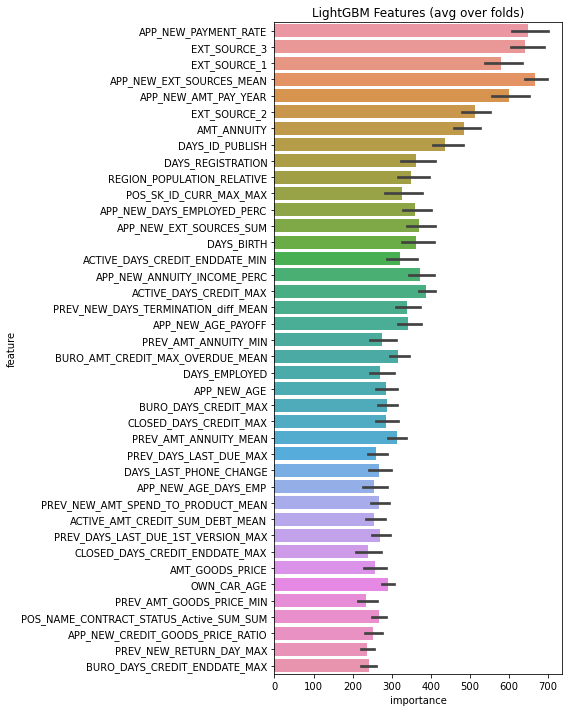

In [13]:
def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    with timer("Run LightGBM with kfold"):
        feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= False, debug= debug)

if __name__ == "__main__":
    submission_file_name = "submission.csv"
    with timer("Full model run"):
        main()